In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 100)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use("ggplot")
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from itertools import product

import warnings 
warnings.filterwarnings("ignore")

### ●问题描述
<p> 1912年4月15日，泰坦尼克号在她的处女航中撞上冰山后沉没，结束了她光辉而短暂的旅途。2224名乘客以及船员中有1502人丧生，存活率仅32%。
<p> 现在我们得到了一份记录了乘客的各种信息以及该乘客是否生还的训练数据和一份含有乘客信息但生还未知的测试数据，我们要根据训练数据建立一个模型来预测测试数据中乘客的生还情况。
   

### ●获取数据

In [2]:
#提取数据
train_row = pd.read_csv("train.csv")
train = train_row.copy(deep=True)
test = pd.read_csv("test.csv")
total = [train, test]
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#查看数据的基本信息
print(train.info()) 
print("*"*10)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
**********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           41

In [4]:
#看一下数据的统计情况
print(train.describe())
print("*"*10)
print(train.describe(include=["O"]))
print(" *"*10)
print(test.describe())
print("*"*10)
print(test.describe(include=["O"]))

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
**********
                          Name   Sex    Ticket Cabin Embarked
count   

In [5]:
#观察缺失值的情况
print(train.isnull().sum()/len(train))
print("*"*10)
print(test.isnull().sum()/len(test))

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64
**********
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64


#### 初步观察后得到一些信息
<p> 训练集中一共有891位乘客信息（577名男性乘客)，测试集中有418位乘客信息(266名男性乘客）；
<p> 训练集（train_df）中一共12列数据，其中Survived列为我们需要预测的标签（label），其他11列为特征（feature）
<p> 数量型数据  
   离散型：SibSp Parch  
   连续型：Age Fare
<p> 分类型数据  
   Name Sex Ticket Cabin Embarked Survived    
   定序型：Pclass
<p> PassengerId是一个序列，对数据没有任何作用    
<p> Survived中，1代表生还，0代表遇难；从训练集的mean中可以看到乘客生还率为38%
<p> Pclass分为1，2，3；中位数是3，可知1代表头等舱，2次之，3为普通席
<p> Age 乘客平均年龄29岁，中位数28岁，最小4个月大，最大80岁
<p> SibSp和Parch跟家庭成员有关，从数据可以看出75%的乘客都是单独出行
<p> Fare中可以看出，有少部分土豪乘客，票价高达512磅。
<p> Name全是独立数据
<p> Ticket有超过75%的独立值
<p> Embarked有S、C、Q三种，S最多，占72%   
<p> 训练集中Age、Cabin和Embarked有缺失值；测试集中Age、Cabin和Fare有缺失值    

### ●分析数据

In [6]:
#先处理数据中的缺失值

for data in total:
    data["Age"].fillna(data["Age"].median(), inplace=True) #用Age的中位数填补缺失值
    data["Embarked"].fillna(data["Embarked"].mode()[0], inplace=True) #用Embarked的众数填补缺失值
    data["Fare"].fillna(data["Fare"].mode()[0], inplace=True) #用Fare的众数填补缺失值
    
    #对于Cabin特征，将有数据值的样本作为have Cabin， null的样本作为have no Cabin
    data.loc[train["Cabin"].notnull(), "Cabin"] = 1
    data["Cabin"].fillna(0, inplace=True)

In [7]:
#删除不需要的特征
drop_feature = ["PassengerId", "Ticket"]

train.drop(drop_feature, 1, inplace=True)

In [8]:
# 检查数据是否还存在缺失值
for data in total:
    print(data.isnull().sum()/len(data))

Survived    0.0
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Cabin       0.0
Embarked    0.0
dtype: float64
PassengerId    0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64


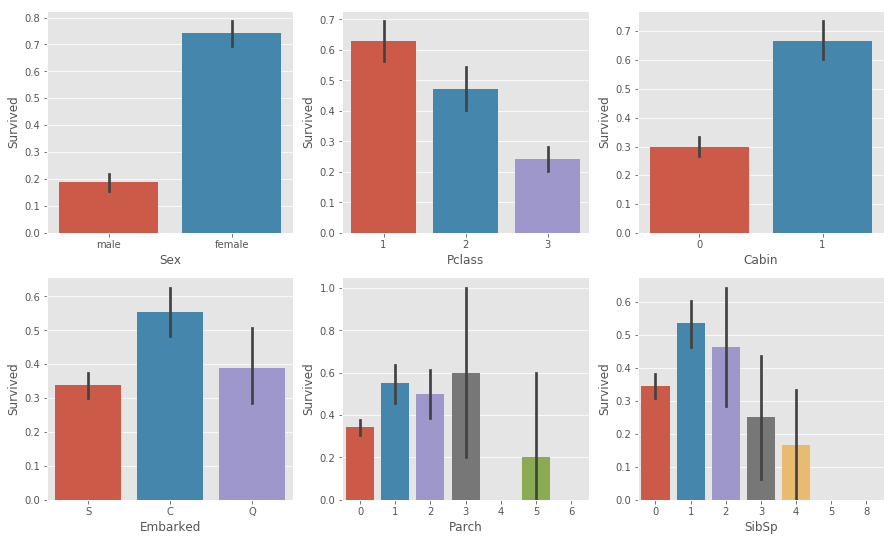

In [27]:
#画图先看一看数据的情况

#画图查看Sex，Pclass，Cabin， Embarked, Parch, SibSp各自的生还率
fig = plt.figure(figsize=(15, 9))

plt.subplot(231)
ax1 = sns.barplot(x="Sex", y="Survived", data=train, estimator=np.mean)

plt.subplot(232)
ax2 = sns.barplot(x="Pclass", y="Survived", data=train, estimator=np.mean)

plt.subplot(233)
ax3 = sns.barplot(x="Cabin", y="Survived", data=train, estimator=np.mean)

plt.subplot(234)
ax4 = sns.barplot(x="Embarked", y="Survived", data=train, estimator=np.mean)

plt.subplot(235)
ax5 = sns.barplot(x="Parch", y="Survived", data=train, estimator=np.mean)

plt.subplot(236)
ax6 = sns.barplot(x="SibSp", y="Survived", data=train, estimator=np.mean)

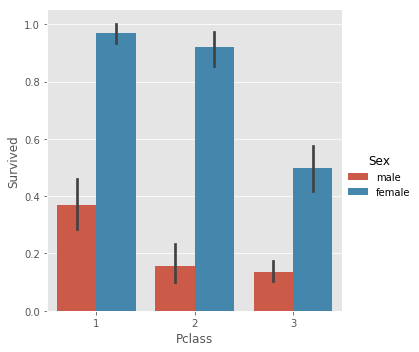

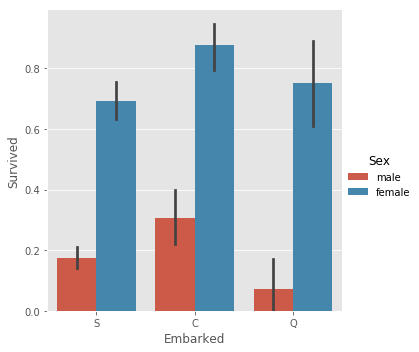

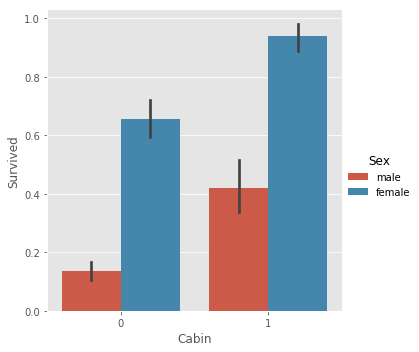

In [57]:
#联系多个特征查看获救情况

#查看在各个Pclass，Embarked，有无Cabin中Sex的获救情况
ax1 = sns.catplot(data=train, x="Pclass", y="Survived", hue="Sex", kind="bar")
ax2 = sns.catplot(data=train, x="Embarked", y="Survived", hue="Sex", kind="bar")
ax3 = sns.catplot(data=train, x="Cabin", y="Survived", hue="Sex", kind="bar")

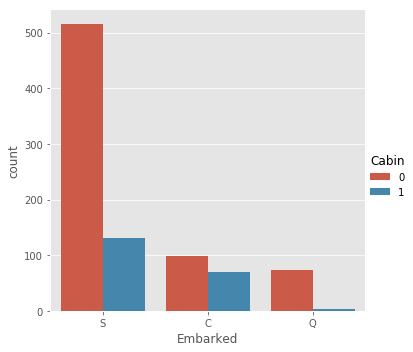

In [61]:
#查看Embarked和Cabin有什么联系
ax = sns.catplot(data=train, x="Embarked", hue="Cabin", kind="count")

<p> 女性超过7成能获救，Pclass的头等舱有6成能获就，而且头等舱中的女性有超过8成的生还率，看来女性和土豪可以优先登上救生船。
<p> 有Cabin的获救率远高于没有Cabin，特别是有Cabin的男士生还率是没有Cabin的两倍，可以推测有Cabin的可能和身份地位有关。
<p> Embarked中C港口的获救率超过了50%，尤其是C港口登船的女性有超过80%的生还率；   
    S港口登船人数最多但获救率最低，很有可能从C港口登船的富人较多，而S港口大部分是工薪阶层。
<p> SibSp和Parch中有很多零相关的数据。

In [ ]:
#接下来查看连续性变量Age和Fare对生还率有什么样的影响

sns.FacetGrid(x="Age", )